In [1]:
## LSTM

import torch
import torch.nn as nn

class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)

        self.fc_1 = nn.Linear(hidden_size, 128) # 완전 연결 계층
        self.fc_2 = nn.Linear(128, num_classes) # 출력층

        self.relu = nn.ReLU()

    def forward(self, x):
        h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device) # 은닉 상태
        c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device) # 셀 상태

        out, (hn, cn) = self.lstm(x, (h_0, c_0))

        hn = hn[-1]
        out = self.relu(hn)
        out = self.fc_1(out) # 은닉 상태 -> 중간 차원
        out = self.relu(out)
        out = self.fc_2(out) # 중간 차원 -> 출력 클래스
        return out

class GRU(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(GRU, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.gru = nn.GRU(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)

        self.fc_1 = nn.Linear(hidden_size, 128)
        self.fc_2 = nn.Linear(128, num_classes)

        self.relu = nn.ReLU()

    def forward(self, x):
        h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        out, (hn) = self.gru(x, (h_0))

        out = self.relu(hn)
        out = self.fc_1(out)
        out = self.relu(out)
        out = self.fc_2(out)
        return out

In [2]:
import matplotlib.pyplot as plt

plt.style.use('Solarize_Light2')

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

cuda = True if torch.cuda.is_available() else False
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

torch.manual_seed(125)

if torch.cuda.is_available() :
    torch.cuda.manual_seed_all(125)

In [3]:
import yfinance as yf

df = yf.download('005930.KS', start='2021-01-01', end='2021-05-31')

df.head(2)

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,005930.KS,005930.KS,005930.KS,005930.KS,005930.KS
Date,,,,,
2021-01-04,76794.867188,78090.202297,74204.196969,74944.388460,38655276
2021-01-05,77627.578125,77627.578125,75499.527712,75499.527712,35335669


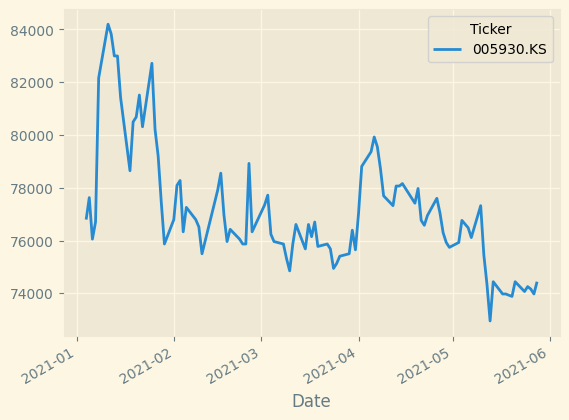

In [4]:
fig = df['Close'].plot()

In [5]:
X = df.drop('Close', axis=1)
y = df[['Close']]

from sklearn.preprocessing import StandardScaler, MinMaxScaler

ms = MinMaxScaler() # 0 ~ 1
ss = StandardScaler() # 평균 0, 분산 1

X_ss = ss.fit_transform(X)
y_ms = ms.fit_transform(y)

X_train = X_ss[:79, :]
X_test = X_ss[79:, :]

y_train = y_ms[:79, :]
y_test = y_ms[79:, :]

print('Training Shape :', X_train.shape, y_train.shape)
print('Testing Shape :', X_test.shape, y_test.shape)

Training Shape : (79, 4) (79, 1)
Testing Shape : (21, 4) (21, 1)


In [6]:
# 데이터셋 형태 및 크기 조정
X_train_tensors = torch.Tensor(X_train)
X_test_tensors = torch.Tensor(X_test)

y_train_tensors = torch.Tensor(y_train)
y_test_tensors = torch.Tensor(y_test)

X_train_tensors_f = torch.reshape(X_train_tensors, 
                                  (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))

X_test_tensors_f = torch.reshape(X_test_tensors,
                                (X_test_tensors.shape[0], 1, X_test_tensors.shape[1]))

print('Training Shape :', X_train.shape, y_train.shape)
print('Testing Shape :', X_test.shape, y_test.shape)

Training Shape : (79, 4) (79, 1)
Testing Shape : (21, 4) (21, 1)


In [7]:
X_train_tensors_f.shape

torch.Size([79, 1, 4])

In [8]:
num_epochs = 1000
learning_rate = 0.0001

input_size=4 # 칼럼 개수
hidden_size=2 # 은닉층 유닛 개수
num_layers=1 # LSTM 계층 개수
num_classes=1 # 클래스 개수

model = LSTM(input_size, hidden_size, num_layers, num_classes)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [9]:
for epoch in range(num_epochs) :
    outputs = model.forward(X_train_tensors_f) # 전방향 학습
    optimizer.zero_grad()
    loss = criterion(outputs, y_train_tensors) # 오차 계싼
    loss.backward() # 기울기 계산
    
    optimizer.step() # 오차 업데이트
    if epoch % 100 == 0 :
        print(f'Epoch : {epoch}, loss : {loss.item():1.5f}')

Epoch : 0, loss : 0.11552
Epoch : 100, loss : 0.04340
Epoch : 200, loss : 0.03605
Epoch : 300, loss : 0.03408
Epoch : 400, loss : 0.03150
Epoch : 500, loss : 0.02803
Epoch : 600, loss : 0.02369
Epoch : 700, loss : 0.01884
Epoch : 800, loss : 0.01373
Epoch : 900, loss : 0.00948


In [10]:
df_x_ss = ss.transform(X)
df_y_ms = ms.transform(y)

df_x_ss = torch.Tensor(df_x_ss)
df_y_ms = torch.Tensor(df_y_ms)
df_x_ss = torch.reshape(df_x_ss, (df_x_ss.shape[0], 1, df_x_ss.shape[1]))

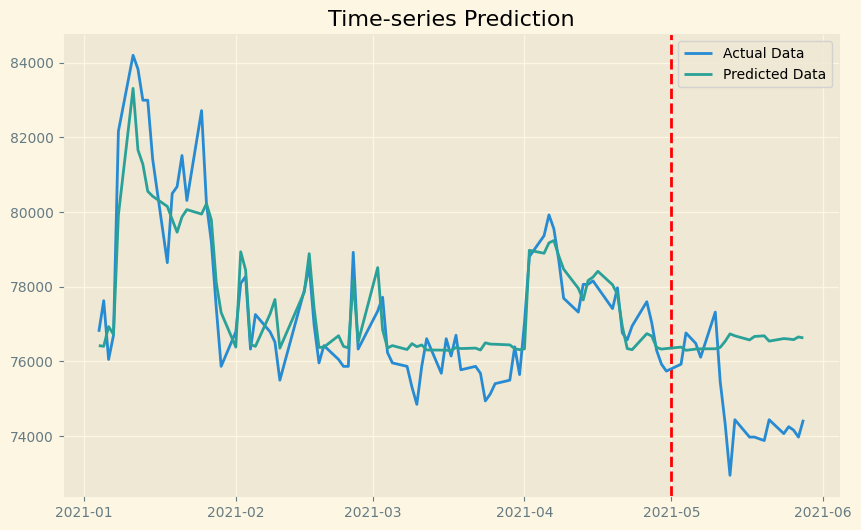

In [11]:
from datetime import datetime

train_predict = model(df_x_ss)
predicted = train_predict.data.numpy()

label_y = df_y_ms.data.numpy()

predicted = ms.inverse_transform(predicted)
label_y = ms.inverse_transform(label_y)
plt.figure(figsize=(10, 6))
plt.axvline(x=datetime(2021,5,1), c='r', linestyle='--')

df['pred'] = predicted
plt.plot(df['Close'], label='Actual Data')
plt.plot(df['pred'], label='Predicted Data')

plt.title('Time-series Prediction')
plt.legend()
plt.show()

In [12]:
num_epochs = 1000
learning_rate = 0.0001

input_size=4
hidden_size=2
num_layers=1
num_classes=1

model=GRU(input_size, hidden_size, num_layers, num_classes)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [13]:
for epoch in range(num_epochs) :
    outputs = model.forward(X_train_tensors_f)
    optimizer.zero_grad()
    loss = criterion(outputs, y_train_tensors)
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0 :
        print(f'Epoch : {epoch}, loss : {loss.item():1.5f}')

/data/jaesung/anaconda3/envs/stock/lib/python3.9/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([79, 1])) that is different to the input size (torch.Size([1, 79, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch : 0, loss : 0.08690
Epoch : 100, loss : 0.03187
Epoch : 200, loss : 0.02046
Epoch : 300, loss : 0.01264
Epoch : 400, loss : 0.00796
Epoch : 500, loss : 0.00568
Epoch : 600, loss : 0.00465
Epoch : 700, loss : 0.00412
Epoch : 800, loss : 0.00380
Epoch : 900, loss : 0.00360


In [14]:
df_x_ss = ss.transform(X)
df_y_ms = ms.transform(y)

df_x_ss = torch.Tensor(df_x_ss)
df_y_ms = torch.Tensor(df_y_ms)
df_x_ss = torch.reshape(df_x_ss, (df_x_ss.shape[0], 1, df_x_ss.shape[1]))

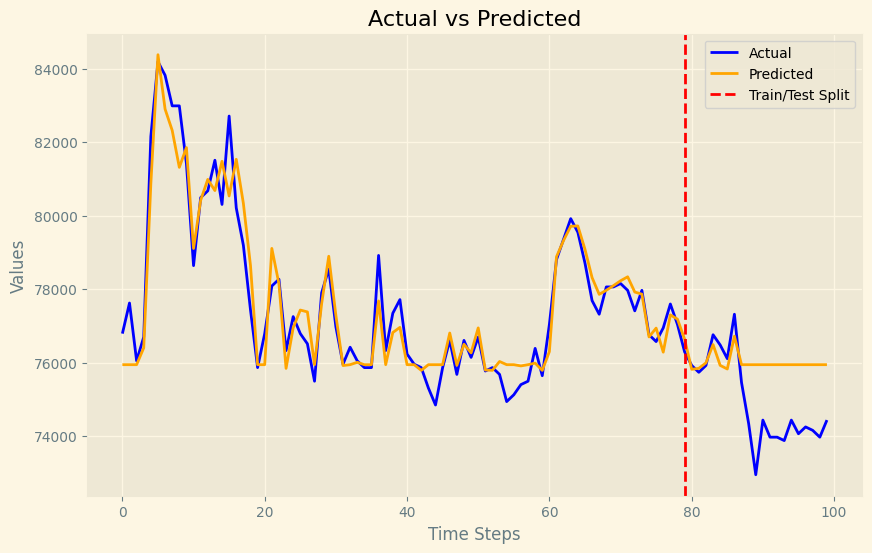

In [17]:
predicted = train_predict.data.numpy()  # Convert tensor to numpy
label_y = df_y_ms.data.numpy()         # Convert tensor to numpy

# Reshape to 2D array for inverse_transform
predicted_2d = predicted.reshape(-1, predicted.shape[-1])  # Keep the last dimension as feature dim
label_y_2d = label_y.reshape(-1, label_y.shape[-1])

# Apply inverse_transform
predicted_rescaled = ms.inverse_transform(predicted_2d)
label_y_rescaled = ms.inverse_transform(label_y_2d)

# Reshape to 1D for plotting
predicted_rescaled_flat = predicted_rescaled.flatten()
label_y_rescaled_flat = label_y_rescaled.flatten()

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(label_y_rescaled_flat, label="Actual", color='blue')
plt.plot(predicted_rescaled_flat, label="Predicted", color='orange')
plt.axvline(x=79, c='r', linestyle='--', label="Train/Test Split")  # 임의의 분할선
plt.legend()
plt.title("Actual vs Predicted")
plt.xlabel("Time Steps")
plt.ylabel("Values")
plt.show()
